In [16]:
!pip install 'transformers[torch]'

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import os

In [18]:
data = pd.read_csv("/content/drive/MyDrive/New_Delhi_reviews.csv")
# https://www.kaggle.com/datasets/arnabchaki/tripadvisor-reviews-2023?resource=download
data.head()

,rating_review,review_full
0,5,"Totally in love with the Auro of the place, re..."
1,5,I went this bar 8 days regularly with my husba...
2,5,We were few friends and was a birthday celebra...
3,5,Fatjar Cafe and Market is the perfect place fo...
4,5,"Hey Guys, if you are craving for pizza and sea..."


## DATA EXPLORATION

In [38]:
data.columns, len(data)

(Index(['rating_review', 'review_full', 'review_length'], dtype='object'),
 147581)

In [20]:
data.describe()

,rating_review
count,147581.000000
mean,4.230280
std,0.969808
min,1.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,5.000000


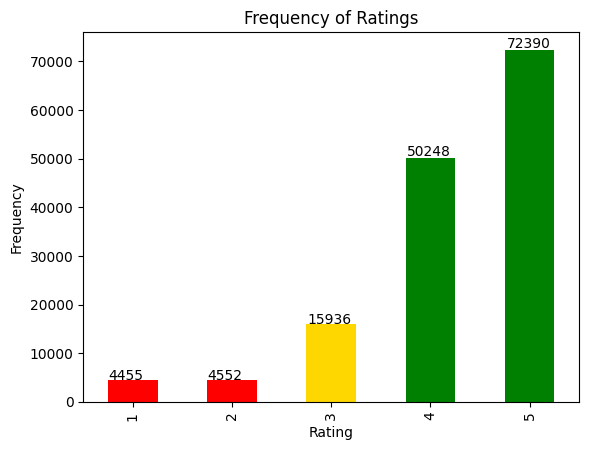

In [44]:
## Distribution of review ratings

# Calculate value counts
counts = data['rating_review'].value_counts().sort_index()

# Define colors based on rating
colors = ['red' if rating < 3 else 'gold' if rating == 3 else 'green' for rating in counts.index]

# Create bar plot
ax = counts.plot(kind='bar', color=colors)

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Ratings')

# Add counts above the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

Total number of rows: 147581
Number of outliers: 11419
Range of outliers: 167 to 1609


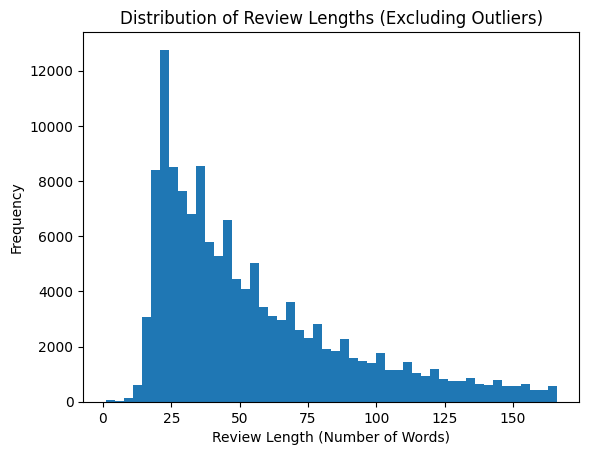

In [22]:
## Distribution of review lengths (by word)

data['review_length'] = data['review_full'].apply(lambda x: len(str(x).split()))
# Calculate IQR
Q1 = data['review_length'].quantile(0.25)
Q3 = data['review_length'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# Filter outliers
outliers = data[(data['review_length'] < lower_bound) | (data['review_length'] > upper_bound)]
filtered_data = data[(data['review_length'] >= lower_bound) & (data['review_length'] <= upper_bound)]

# Print number of outliers and total rows
print(f"Total number of rows: {data.shape[0]}")
print(f"Number of outliers: {outliers.shape[0]}")

# Print range of outliers
if not outliers.empty:
    print(f"Range of outliers: {outliers['review_length'].min()} to {outliers['review_length'].max()}")

# Plot the histogram without outliers
plt.hist(filtered_data['review_length'], bins=50)
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths (Excluding Outliers)')
plt.show()


Correlation between rating and review length: -0.10584262073666366


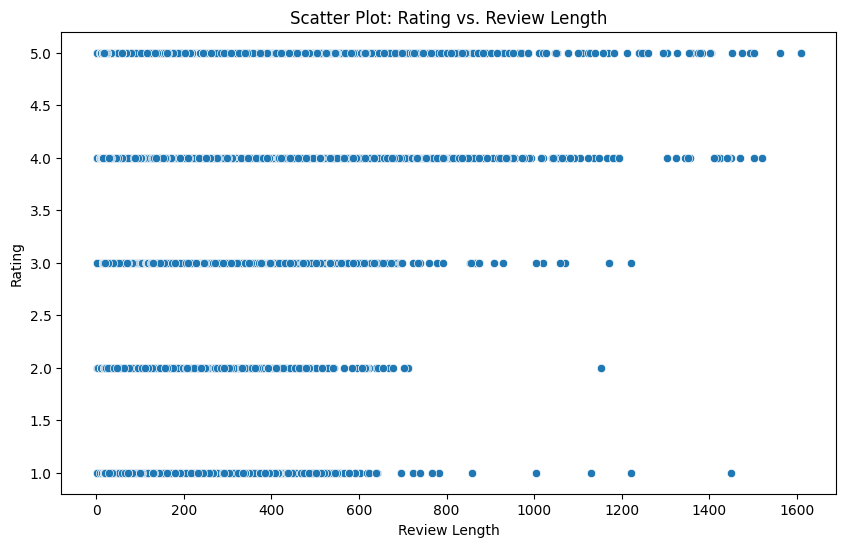

In [23]:
## Are negative reviews longer?

# Compute correlation
correlation = data['rating_review'].corr(data['review_length'])
print(f"Correlation between rating and review length: {correlation}")

# Scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x='review_length', y='rating_review', data=data)
plt.title('Scatter Plot: Rating vs. Review Length')
plt.xlabel('Review Length')
plt.ylabel('Rating')
plt.show()

## DATA PREPROCESSING

In [24]:
## Convert non-string type reviews to strings

print(data['review_full'].apply(type).value_counts())
data['review_full'] = data['review_full'].astype(str)
print(data['review_full'].apply(type).value_counts())

<class 'str'>      147579
<class 'float'>         2
Name: review_full, dtype: int64
<class 'str'>    147581
Name: review_full, dtype: int64


In [25]:
empty_or_whitespace = data['review_full'].apply(lambda x: str(x).strip() == "")
print("Empty or whitespace-only strings:", empty_or_whitespace.sum())

Empty or whitespace-only strings: 0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


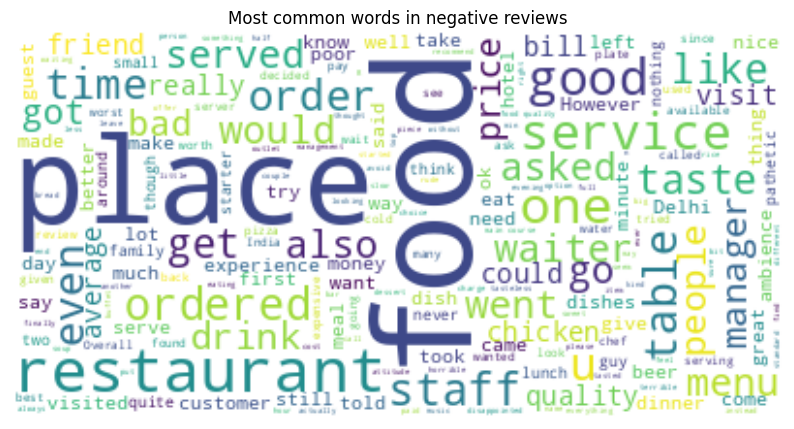

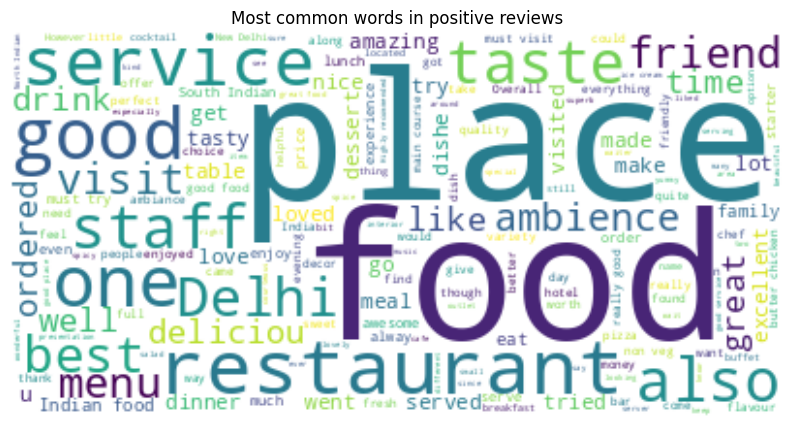

In [26]:
import pandas as pd
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk

# Download stopwords from NLTK if you haven't done so yet
nltk.download('stopwords')

# Assuming your dataframe is named df
negative_reviews = data[data['rating_review'].isin([1,2])]
positive_reviews = data[data['rating_review'].isin([4,5])]

# Join all the reviews into one string
negative_text = " ".join(review for review in negative_reviews.review_full)
positive_text = " ".join(review for review in positive_reviews.review_full)

# Create stopword list:
stopwords = set(stopwords.words('english'))

# Generate a word cloud image
negative_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(negative_text)
positive_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(positive_text)

# Display the generated image for negative reviews:
plt.figure(figsize = (10,10))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most common words in negative reviews')
plt.show()

# Display the generated image for positive reviews:
plt.figure(figsize = (10,10))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most common words in positive reviews')
plt.show()

In [27]:
## Train-val-test (60/20/20) split on 50k random rows

# Get 50k random rows
data_sample = data.sample(n=50000, random_state=1)

# Split the data into train and temp sets
data_train, data_temp = train_test_split(data_sample, test_size=0.4, random_state=1)

# Split the temp data into validation and test sets
data_val, data_test = train_test_split(data_temp, test_size=0.5, random_state=1)

data_train = data_train.reset_index().drop(columns=['index'])
data_val = data_val.reset_index().drop(columns=['index'])
data_test = data_test.reset_index().drop(columns=['index'])

len(data_train), len(data_val), len(data_test)

(30000, 10000, 10000)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
## Create PyTorch dataset and dataloader, which will handle padding, truncation, special_tokens, max_length, etc, for testing of the baseline model

# Step 1: Define a PyTorch Dataset class
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_length):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        if label in (1,2):
          label = 0
        elif label == 3:
          label = 1
        else:
          label = 2

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


## BASELINE MODEL - ROBERTA BASE SENTIMENT

In [30]:
# baseline_name = "cardiffnlp/twitter-roberta-base-sentiment"
# # https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
# max_length = 500
# baseline_tokenizer = AutoTokenizer.from_pretrained(baseline_name)

# baseline_train_dataset = ReviewsDataset(
#     reviews=data_train['review_full'].to_numpy(),
#     labels=data_train['rating_review'].to_numpy(),
#     tokenizer=baseline_tokenizer,
#     max_length=max_length
# )

# baseline_val_dataset = ReviewsDataset(
#     reviews=data_val['review_full'].to_numpy(),
#     labels=data_val['rating_review'].to_numpy(),
#     tokenizer=baseline_tokenizer,
#     max_length=max_length
# )

# baseline_test_dataset = ReviewsDataset(
#     reviews=data_test['review_full'].to_numpy(),
#     labels=data_test['rating_review'].to_numpy(),
#     tokenizer=baseline_tokenizer,
#     max_length=max_length
# )

# # Wrap Dataset instances into PyTorch Dataloader objects
# batch_size = 32

# train_dataloader = DataLoader(baseline_train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(baseline_val_dataset, batch_size=batch_size, shuffle=False)
# test_dataloader = DataLoader(baseline_test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
# ## Calculate accuracy of baseline model, roberta sentiment pre-trained

# # Prepare the model and tokenizer
# baseline_model = AutoModelForSequenceClassification.from_pretrained(baseline_name).to(device)

# # Prepare empty list for true labels and predictions
# true_labels = []
# pred_labels = []

# baseline_model.eval()  # Set the model to evaluation mode

# with torch.no_grad():  # Deactivate gradients for the following computations
#     for batch in test_dataloader:
#         # Move batch tensors to the right device
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)

#         # Forward pass, get model outputs
#         outputs = baseline_model(input_ids=input_ids, attention_mask=attention_mask)

#         # Get the predicted labels
#         _, preds = torch.max(outputs.logits, dim=1)

#         # Move labels and preds to CPU to calculate accuracy later
#         labels = labels.detach().cpu().numpy()
#         preds = preds.detach().cpu().numpy()

#         # Append true label and prediction to lists
#         true_labels.extend(labels.tolist())
#         pred_labels.extend(preds.tolist())

# # Calculate accuracy
# accuracy = accuracy_score(true_labels, pred_labels)
# print('Accuracy:', accuracy) # .8724

# # Calculate F1 score
# f1 = f1_score(true_labels, pred_labels, average='weighted')  # 'weighted' takes into account imbalance in labels
# print('F1 Score:', f1) # .8484


## FINE-TUNE ROBERTA BASE SENTIMENT

In [32]:
# ## Fine-tune baseline model from roberta sentiment - https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment

# # Load pre-trained model and tokenizer
# baselineFT_model = AutoModelForSequenceClassification.from_pretrained(baseline_name).to(device)
# baseline_tokenizer = AutoTokenizer.from_pretrained(baseline_name)

# # Fine-tuning setup
# epochs = 3
# optimizer = AdamW(baselineFT_model.parameters(), lr=1e-5)

# # Fine-tuning loop
# baselineFT_model.train()
# for epoch in range(epochs):
#     total_loss = 0
#     progress = tqdm(total=len(train_dataloader), desc='Epoch {}'.format(epoch + 1))

#     # Training loop
#     for batch in train_dataloader:
#         optimizer.zero_grad()

#         # Move tensors to GPU
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)

#         outputs = baselineFT_model(input_ids=input_ids, attention_mask=attention_mask)

#         # Calculate loss
#         loss = F.cross_entropy(outputs.logits, labels)
#         total_loss += loss.item()

#         # Backpropagate loss
#         loss.backward()

#         # Update weights
#         optimizer.step()

#         progress.update(1)
#     progress.close()

#     # Print loss for this epoch
#     print("Loss: ", total_loss / len(train_dataloader))


# ## Evaluate fine-tuned baseline model
# baselineFT_model.eval()
# true_labels = []
# pred_labels = []

# with torch.no_grad():
#     for batch in test_dataloader:
#         # Move tensors to GPU
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)

#         # Forward pass
#         outputs = baselineFT_model(input_ids=input_ids, attention_mask=attention_mask)

#         # Get the predicted labels
#         _, preds = torch.max(outputs.logits, dim=1)

#         # Move labels and preds to CPU for calculating accuracy
#         labels = labels.detach().cpu().numpy()
#         preds = preds.detach().cpu().numpy()

#         true_labels.extend(labels.tolist())
#         pred_labels.extend(preds.tolist())

# # Calculate accuracy
# accuracy = accuracy_score(true_labels, pred_labels)
# print('Accuracy:', accuracy) # .9111

# # Calculate F1 score
# f1 = f1_score(true_labels, pred_labels, average='weighted')  # 'weighted' takes into account imbalance in labels
# print('F1 Score:', f1) # .9061

# ## Save fine-tuned baseline model

# # Specify the directory you want to save in
# save_directory = "/content/drive/MyDrive/TripAdvisor_models/baselineFT_model"

# # Create the directory if it doesn't exist
# if not os.path.exists(save_directory):
#     os.makedirs(save_directory)

# # Save the model
# baselineFT_model.save_pretrained(save_directory)

## FINE-TUNE MINILM

In [33]:
# ## Fine-tune pre-trained model from MiniLM - https://huggingface.co/microsoft/MiniLM-L12-H384-uncased

# # Load pre-trained model and tokenizer
# minilm_name = "microsoft/MiniLM-L12-H384-uncased"
# # https://huggingface.co/microsoft/MiniLM-L12-H384-uncased
# max_length = 380
# minilm_tokenizer = AutoTokenizer.from_pretrained(minilm_name)
# minilm_model = AutoModelForSequenceClassification.from_pretrained(minilm_name, num_labels=3).to(device)

# # Prepare data
# minilm_train_dataset = ReviewsDataset(
#     reviews=data_train['review_full'].to_numpy(),
#     labels=data_train['rating_review'].to_numpy(),
#     tokenizer=minilm_tokenizer,
#     max_length=max_length
# )

# minilm_val_dataset = ReviewsDataset(
#     reviews=data_val['review_full'].to_numpy(),
#     labels=data_val['rating_review'].to_numpy(),
#     tokenizer=minilm_tokenizer,
#     max_length=max_length
# )

# minilm_test_dataset = ReviewsDataset(
#     reviews=data_test['review_full'].to_numpy(),
#     labels=data_test['rating_review'].to_numpy(),
#     tokenizer=minilm_tokenizer,
#     max_length=max_length
# )

# # Wrap Dataset instances into PyTorch Dataloader objects
# batch_size = 32

# train_dataloader = DataLoader(minilm_train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(minilm_val_dataset, batch_size=batch_size, shuffle=False)
# test_dataloader = DataLoader(minilm_test_dataset, batch_size=batch_size, shuffle=False)


# # Fine-tuning setup
# epochs = 3
# optimizer = AdamW(minilm_model.parameters(), lr=1e-5)

# # Fine-tuning loop
# minilm_model.train()
# for epoch in range(epochs):
#     total_loss = 0
#     progress = tqdm(total=len(train_dataloader), desc='Epoch {}'.format(epoch + 1))

#     # Training loop
#     for batch in train_dataloader:
#         optimizer.zero_grad()

#         # Move tensors to GPU
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)

#         outputs = minilm_model(input_ids=input_ids, attention_mask=attention_mask)

#         # Calculate loss
#         loss = F.cross_entropy(outputs.logits, labels)
#         total_loss += loss.item()

#         # Backpropagate loss
#         loss.backward()

#         # Update weights
#         optimizer.step()

#         progress.update(1)
#     progress.close()

#     # Print loss for this epoch
#     print("Loss: ", total_loss / len(train_dataloader))


# ## Evaluate raw pre-trained model
# minilm_model.eval()
# true_labels = []
# pred_labels = []

# with torch.no_grad():
#     for batch in test_dataloader:
#         # Move tensors to GPU
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)

#         # Forward pass
#         outputs = minilm_model(input_ids=input_ids, attention_mask=attention_mask)

#         # Get the predicted labels
#         _, preds = torch.max(outputs.logits, dim=1)

#         # Move labels and preds to CPU for calculating accuracy
#         labels = labels.detach().cpu().numpy()
#         preds = preds.detach().cpu().numpy()

#         true_labels.extend(labels.tolist())
#         pred_labels.extend(preds.tolist())

# # Calculate accuracy
# accuracy = accuracy_score(true_labels, pred_labels)
# print('Accuracy:', accuracy) # 0.9018

# # Calculate F1 score
# f1 = f1_score(true_labels, pred_labels, average='weighted')  # 'weighted' takes into account imbalance in labels
# print('F1 Score:', f1) # 0.8956

# ## Save fine-tuned miniLM model

# # Specify the directory you want to save in
# save_directory = "/content/drive/MyDrive/TripAdvisor_models/minilmFT_model"

# # Create the directory if it doesn't exist
# if not os.path.exists(save_directory):
#     os.makedirs(save_directory)

# # Save the model
# minilm_model.save_pretrained(save_directory)

## PUSH MODELS TO HF HUB

In [34]:
# from huggingface_hub import notebook_login
# notebook_login()

In [35]:
# # MiniLM fine-tuned model
# minilm_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/TripAdvisor_models/minilmFT_model")
# minilm_model.push_to_hub("gosorio/minilmFT_TripAdvisor_Sentiment")

# # Load pre-trained model and tokenizer
# model_name = "gosorio/minilmFT_TripAdvisor_Sentiment"
# tokenizer_name = "microsoft/MiniLM-L12-H384-uncased" # the standard MiniLM
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)

In [36]:
# # Roberta sentiment fine-tuned model
# sentiment_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/TripAdvisor_models/baselineFT_model")
# sentiment_model.push_to_hub("gosorio/robertaSentimentFT_TripAdvisor")

# # Load pre-trained model and tokenizer
# model_name = "gosorio/robertaSentimentFT_TripAdvisor"
# tokenizer_name = "cardiffnlp/twitter-roberta-base-sentiment"
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)